In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

## load dump file

In [2]:
def load_lammps_dump(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Find the number of particles
    for i, line in enumerate(lines):
        if line.startswith('ITEM: NUMBER OF ATOMS'):
            num_particles = int(lines[i+1].strip())
            break
        
        # Find the box dimensions
    for i, line in enumerate(lines):
        if line.startswith('ITEM: BOX BOUNDS'):
            box_bounds = [list(map(float, bounds.split())) for bounds in lines[i+1:i+4]]
            break

    # Find the starting line of the atomic positions
    start_lines = []
    for i, line in enumerate(lines):
        if line.startswith('ITEM: ATOMS'):
            start_line = i + 1
            start_lines.append(start_line)

    # Initialize arrays to store the data
    ntime = len(start_lines)
    positions = np.zeros((ntime, num_particles, 3))
    atom_ids = np.zeros(num_particles, dtype=int)
    atom_types = np.zeros(num_particles, dtype=int)
    
    # atom id and type
    start_line_0 = start_lines[0]
    for i in range(num_particles):
        line = lines[start_line_0+i]
        data = line.split()
        atom_ids[i] = int(data[0])
        atom_types[i] = int(data[1])

    # Parse the atomic positions, atom IDs, and atom types
    for it, start_line_t in tqdm(enumerate(start_lines)):
        for i in range(num_particles):
            line = lines[start_line_t+i]
            data = line.split()
            positions[it, i, :] = [float(data[2]), float(data[3]), float(data[4])]

    return positions, atom_ids, atom_types, box_bounds


In [3]:
positions, atom_ids, atom_types, box_bounds = load_lammps_dump("./min_stress_cube8.dump")

927it [00:01, 576.44it/s]


# calculate MSD

In [4]:
n_times = int((positions.shape[0]-1)/2)
n_particles = len(atom_ids)

msd = np.zeros(n_times)
t_list = np.arange(n_times)*2

position_0 = positions[t_list[0]]
for it, t in tqdm(enumerate(t_list)):
    position_t = positions[t]
    msd_t = np.sum((position_t-position_0)**2)/n_particles
    msd[it] += msd_t


463it [00:00, 125709.66it/s]


Text(0, 0.5, '$\\rm{MSD}$')

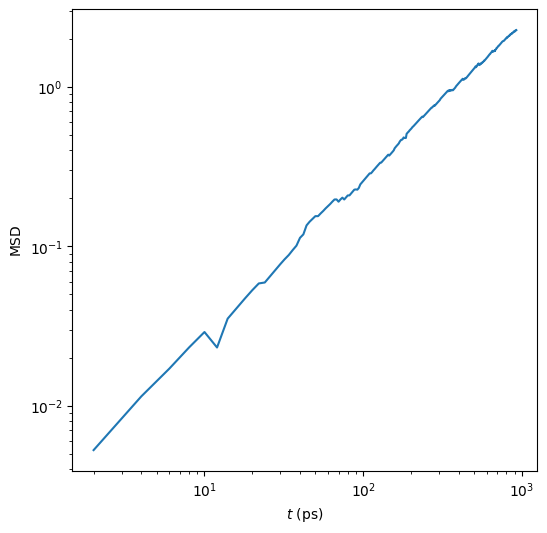

In [8]:
timestep = 1
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.plot(t_list[1:]*timestep,msd[1:])
ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_ylim([1e-1,10])
# ax.set_xlim([1,1e4])

ax.set_xlabel(r"$t$ (ps)")
ax.set_ylabel(r"$\rm{MSD}$")